# Image Processing SS 20 - Assignment - 04

### Deadline is 20.5.2020 at 11:55am

Please solve the assignments together with a partner.
I will run every notebook. Make sure the code runs through. Select `Kernel` -> `Restart & Run All` to test it.
Please strip the output from the cells, either select `Cell` -> `All Output` -> `Clear` or use the `nb_strip_output.py` script / git hook.

In [41]:
# display the plots inside the notebook
%matplotlib inline

In [42]:
import numpy as np
import matplotlib.pyplot as plt
import pylab
import random
from io import BytesIO
from PIL import Image
pylab.rcParams['figure.figsize'] = (12, 12)   # This makes the plot bigger

In [53]:
def average(img): 
    return np.mean(img) 
 

def sd(img):             
    return np.std(img)


def mul(matrix_a, matrix_b):
    if(matrix_a.shape != matrix_b.shape):
        print("Ungleicher Shape")
        return
    x, y = matrix_a.shape
    res = np.zeros_like(matrix_a)
    for i in range(x):
        for j in range(y):
            res[i][j] = matrix_a[i][j] * matrix_b[i][j]
    return res
            


def sdxy(img,img1):
    x,y  = img .shape
    avg = average(img)
    avg1 = average(img1)
    sd = 0
    for i in range(x):
        for j in range(y):
            sd += (img[i,j] - avg) * (img1[i,j] - avg1)             
    return sd / ((x * y) - 1)

def sampling(x,i,j):
    result = np.zeros((11,11))
    for k in range(-5,6): 
        for l in range(-5,6): 
            result[k,l] = ( x[ i + l ,j + k, 0] + x[ i + l ,j + k, 1] + x[ i + l ,j + k, 2] ) / 3 
    return result

"""
def gauss(size, sigma):
    x, y = np.mgrid[-size//2 + 1:size//2 + 1, -size//2 + 1:size//2 + 1]
    g = np.exp(-((x**2 + y**2)/(2.0*sigma**2)))
    return g/g.sum()
"""

# def gauss(size, sigma):

#     mat = np.zeros((size, size))

#     for i in range(size):
#         for j in range(size)


#     return 

'\ndef gauss(size, sigma):\n    x, y = np.mgrid[-size//2 + 1:size//2 + 1, -size//2 + 1:size//2 + 1]\n    g = np.exp(-((x**2 + y**2)/(2.0*sigma**2)))\n    return g/g.sum()\n'

# Exercise 1 - Qualify sharpness and noise - 5 Points

Determine the noise and sharpness in the images. Plot image number vs noise

Please download sample picture from [here](http://sipi.usc.edu/database/misc.zip) and place them next to your assignment (inside the misc folder).

In [44]:
# Load the pictures here
sample_images = []
direc = 'misc/' # directory of the sample pictures relative to your notebook
for number in [1,3,5,6]:
    sample_images.append(
        np.array(Image.open(direc+'4.2.0'+str(number)+'.tiff'))
    )
for name in ['house']:
    sample_images.append(
        np.array(Image.open(direc+name+'.tiff'))
    )


<BarContainer object of 5 artists>

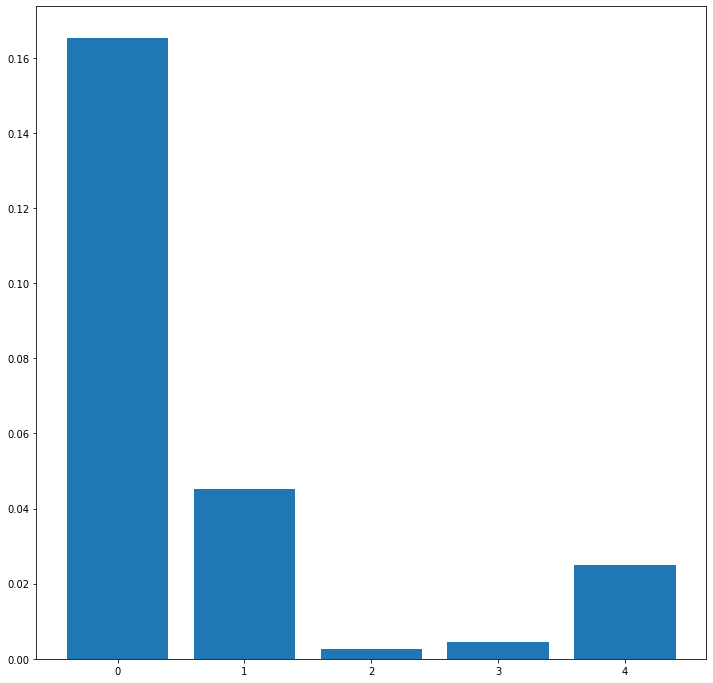

In [45]:
def average_noise(img, x, y):
    avg = 0
    for i in range(11):
        for j in range(11):
            avg += (img[x+i,y+j,0]+img[x+i,y+j,1]+img[x+i,y+j,2]) / 3 
    avg /= 121
    return avg

def sd_noise(img, x, y):
    avg = average_noise(img, x, y)
    sd = 0
    for i in range(11):
        for j in range(11):
            pixel_Value = (img[x+i,y+j,0]+img[x+i,y+j,1]+img[x+i,y+j,2])/3
            sd += (pixel_Value - avg)**2   
    sd /= 121
    return sd


k = 0
def qualify_noise(img):
    """Qualify the noise based on the std of a gaussian model.
       You may find a window that is contant in the images.
    """
    global k
    x, y = 0, 0
    if k == 0:
        x, y = 410, 340 #
    elif k == 1: 
        x, y = 420, 280 #
    elif k == 2: 
        x, y = 280, 495 #
    elif k == 3: 
        x, y = 130, 300 #
    elif k == 4: 
        x, y = 370, 240 #
    k += 1
    return sd_noise(img/255, x, y) **(0.5) #normalized value for rgb

plt.bar(range(len(sample_images)), [qualify_noise(i) for i in sample_images])


<BarContainer object of 5 artists>

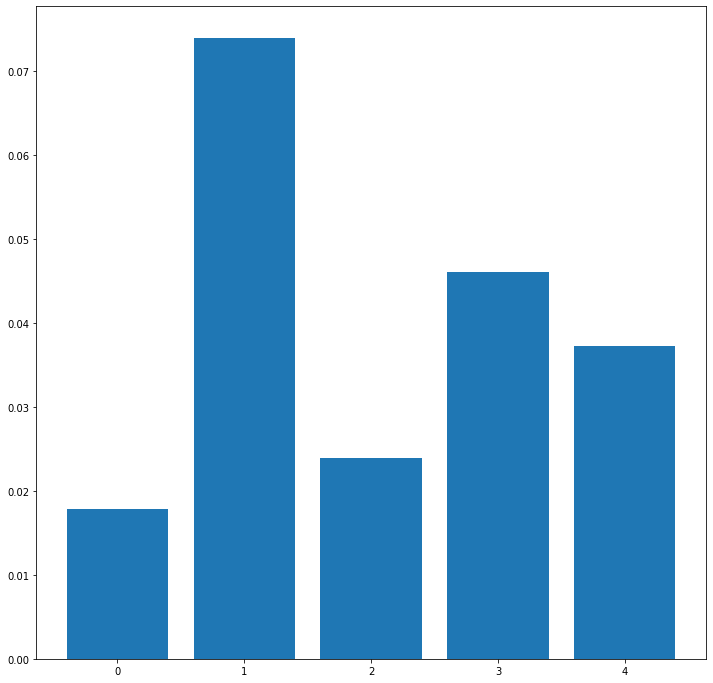

In [46]:
def euclid_distance(x,y):
    return ( (x[0] - y[0])**2 + (x[1] - y[1])**2 + (x[2] - y[2])**2 )** 0.5

def distance(x,y):
    return abs( ( (x[0] + x[1] + x[2]) /3) - ((y[0] + y[1] + y[2]) /3) ) 

# over all lines
def qualify_sharpness(img):
    """Qualify the sharpness based on the average pixel differences."""
    x,y,z = img.shape
    dist = 0
    for i in range (x):
        for j in range(y - 1):
            dist += distance(img[i,j],img[i,j+1])
    return dist / (x * y * 255) 

plt.bar(range(len(sample_images)), [qualify_sharpness(i) for i in sample_images])

Does the result match your expectations? If not what processing step can be done?

# Exercise 2 - SSIM JPEG Compression - 5 Points

In [47]:
def jpeg_enocde(img, quality):
    pil_img = Image.fromarray(img)
    buffer = BytesIO()
    pil_img.save(buffer, "JPEG", quality=quality)
    return buffer

def jpeg_decode(buffer):
    img = Image.open(buffer)
    return np.array(img)

def jpeg_quality_filter(img, quality):
    as_jpeg = jpeg_enocde(img, quality)
    return jpeg_decode(as_jpeg)

In [48]:
images_for_jpeg = sample_images[2::]
len(images_for_jpeg)

3

In [49]:
images10 = [jpeg_quality_filter(img, 10) for img in images_for_jpeg]
images50 = [jpeg_quality_filter(img, 50) for img in images_for_jpeg]
images80 = [jpeg_quality_filter(img, 80) for img in images_for_jpeg]

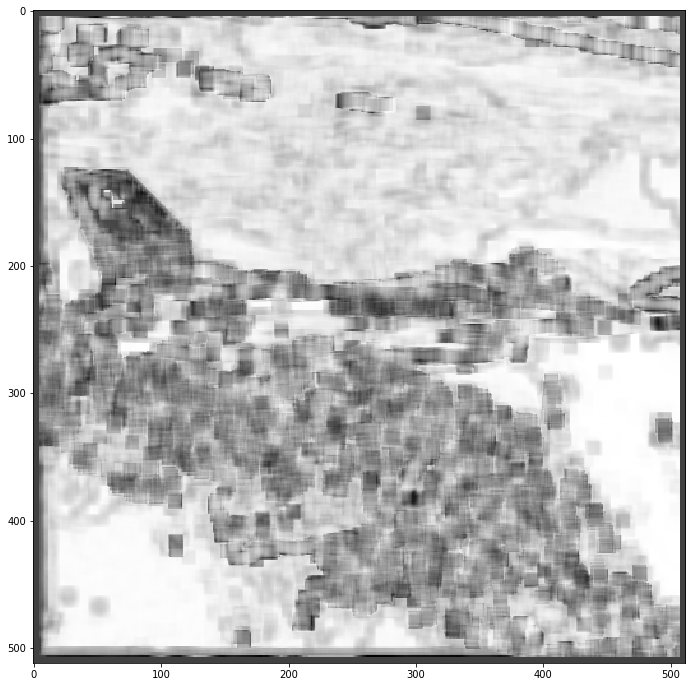

KeyboardInterrupt: 

In [54]:
def ssim(img, filtered_img):
    """The SSIM similarity measure. Use the parameters from the paper 
    as on the second to last slide from the lecture
    """

    #img = img/255
    #filtered_img = filtered_img /  255
    x,y,_ = img.shape
    mssim,ssim_map = 0, np.zeros((x,y)) 
    window = np.ones((11,11))
    K1 = 0.01
    K2 = 0.03
    L = 255 
    c1 = (K1*L)**2
    c2 = (K2*L)**2
    
    for i in range(x):
        for j in range(y):
            if(i - 5 < 0 or i + 5 >= x or j - 5 < 0 or j + 5 >= y ):
                continue
            sample_img = mul(window, sampling(img, i, j))
            sample_imgf = mul(window, sampling(filtered_img, i, j))
            avg_img = average(sample_img)
            avg_fi  = average(sample_imgf)
            sd_img_fi = sdxy(sample_img,sample_imgf)
            sd_img = sd(sample_img)
            sd_fi = sd(sample_imgf) 
            tmp = ((2*avg_img * avg_fi + c1) * (2*sd_img_fi + c2) )/ ((avg_img ** 2 + avg_fi ** 2 + c1) * (sd_img ** 2 + sd_fi ** 2 + c2))
            mssim  += tmp
            ssim_map[i,j] = tmp
    
    plt.imshow(ssim_map, cmap='gray')
    plt.show()
    return (mssim /(x*y)) #, ssim_map


for i, img in enumerate(images_for_jpeg):
    compressed_images = [images10[i], images50[i], images80[i]]
    plt.bar(range(len(compressed_images)),
             [ssim(img, comp) for comp in compressed_images])
    plt.show()